In [2]:
import sys
sys.path.append('../src')
import hyperopt as hp
import numpy as np
import scipy as sc
import models as hm
import benchmark_functions as bf
import benchmarking_functions as bench
from sklearn.preprocessing import StandardScaler
import sklearn as sk
from sklearn.model_selection import train_test_split
import torch
import matplotlib.pyplot as plt
import mlflow
from hyperopt import fmin, tpe, hp, SparkTrials, STATUS_OK, Trials
from datetime import datetime
import torch.nn as nn
import cvxpy as cp
import mlflow.pytorch
from mlflow.models.signature import infer_signature, set_signature
import hyperopt
from functools import partial
import pandas as pd
import seaborn as sns

In [7]:
from importlib.metadata import version
print(version('numpy'),version('scipy'),version('cvxpy'),version('hyperopt'), version('mlflow'), version('pandas'), version('scikit-learn'))

1.26.2 1.11.4 1.4.1 0.2.7 2.10.2 2.1.4 1.3.2


First, run this from terminal :

mlflow server --host 127.0.0.1 --port 8081

In [2]:
mlflow.set_tracking_uri(uri="http://127.0.0.1:8081")
# Create a new MLflow Experiment
experiment = mlflow.set_experiment("name_experiment")

# Get Experiment Details
print("Experiment_id: {}".format(experiment.experiment_id))
print("Artifact Location: {}".format(experiment.artifact_location))
print("Name: {}".format(experiment.name))
print("Tags: {}".format(experiment.tags))
print("Lifecycle_stage: {}".format(experiment.lifecycle_stage))

Experiment_id: 558240818870061810
Artifact Location: mlflow-artifacts:/558240818870061810
Name: JOPT_benchmark_functions_mac
Tags: {}
Lifecycle_stage: active


In [3]:


search_space_DR_SCNN = {'radius': hp.loguniform('radius',-8, 1),
                'max_neurons': hp.quniform('max_neurons', 10, 300, 1),
                'wasserstein': hp.choice('wasserstein', ["l1", "l2"]),
                }

search_space_SCNN = {'lamb_reg': hp.loguniform('lamb_reg',-8, 1),
                'max_neurons': hp.quniform('max_neurons', 10, 300, 1),
                'regularizer': hp.choice('regularizer', ["LASSO", "RIDGE"]),
                }

search_space_SCNN_no_reg = {#'lamb_reg': hp.loguniform('lamb_reg',-8, 1),
                'max_neurons': hp.quniform('max_neurons', 10, 300, 1),
                }


search_space_DR_linreg = {'radius': hp.loguniform('radius',-8, 1),
                          'wasserstein': hp.choice('wasserstein', ["l1", "l2"]),
                }

search_space_linreg = {'lamb_reg': hp.loguniform('lamb_reg',-8, 1),
                'regularizer': hp.choice('regularizer', ["LASSO","RIDGE"]),
                }

search_space_FNN =  {'batch_size' : hp.quniform('batch_size',2, 100, 1),
                'learning_rate': hp.loguniform('learning_rate',-8, 1),
                'n_hidden' : hp.quniform('n_hidden',10, 300, 1),
                'n_epochs': hp.quniform( 'n_epochs',1, 1000, 1),
                'dropout_p': hp.uniform('dropout_p', 0.01, 0.4)}


In [4]:
rng = np.random.default_rng(42)
criterion = nn.L1Loss()

solver_name = "CLARABEL"
max_evals = 400
max_evals_FNN = int(max_evals/4)
verbose = False
N = 2000
train_size = 0.75
test_size = 0.2
n_corrupted_points = int(N*0.8*0.1) #int(0.6*N)
n_dim = 4

FUNCTIONS_LIST = [ 
	#[bf.Hypersphere, n_dim, "Hypersphere"], 
	#[bf.Hyperellipsoid, n_dim, "Hyperellipsoid"], 
	#[bf.PitsAndHoles,2, "PitsAndHoles"],
	[bf.Ackley, n_dim, "Ackley"],
	#[bf.Rosenbrock, n_dim, "Rosenbrock"],
	#[bf.Rastrigin,n_dim, "Rastrigin"],
	#[bf.Schwefel,n_dim, "Schwefel"],
	#[bf.Griewank,n_dim, "Griewank"],
	#[bf.Michalewicz,n_dim, "Michalewicz"],
	#[bf.EggHolder,n_dim, "EggHolder"], 				
	[bf.Keane,n_dim, "Keane"],
	#[bf.Rana,n_dim, "Rana"], 			
	#[bf.Easom,2, "Easom"], # 2 dims
	#[bf.DeJong5,2, "DeJong5"], # 2 dims
	#[bf.GoldsteinAndPrice,2, "GoldsteinAndPrice"],  # 2 dims
	[bf.PichenyGoldsteinAndPrice,2, "PichenyGoldsteinAndPrice"],
	#[bf.StyblinskiTang,n_dim, "StyblinskiTang"],
	[bf.McCormick, 2, "McCormick"], # 2 dims
	#[bf.MartinGaddy,2, "MartinGaddy"],
	#[bf.Schaffer2, 2, "Schaffer2"], # 2 dims
	#[bf.Himmelblau, 2, "Himmelblau"],# 2 dims
	]

In [5]:
for benchmark_func in FUNCTIONS_LIST:
    data = bench.dataset_wrapper(benchmark_func=benchmark_func[0], n_dim=benchmark_func[1], rng =rng, N = N, train_size=train_size, test_size=test_size)
    func_name = benchmark_func[2]
    data.generate_data_wasserstein_corrupt_both(corrupt_data_points= n_corrupted_points, min_distance=0.05, n_projections=100, k_multiplier=1.5, L=2, seed=42)


    print(f"SCNN_no_reg on {func_name}: \n")
    fmin_SCNN_no_reg = partial(bench.objective_SCNN_no_reg, data = data, criterion = criterion, solver_name = solver_name, experiment=experiment, n_corrupted_points = n_corrupted_points, func_name=func_name, verbose=verbose)
    argmin_SCNN_no_reg = fmin(fn=fmin_SCNN_no_reg,
              space=search_space_SCNN_no_reg,
              algo= hyperopt.anneal.suggest, #hyperopt.tpe.suggest, # try anneal.suggest
              max_evals=int(max_evals)) #trials=spark_trials)
    
    print(f"WaDiRO SCNN on {func_name}: \n")
    fmin_DR_SCNN = partial(bench.objective_DR_SCNN, data = data, criterion = criterion, solver_name = solver_name, experiment=experiment, n_corrupted_points=n_corrupted_points, func_name=func_name, verbose=verbose)
    argmin_DR_SCNN = fmin(fn=fmin_DR_SCNN,
              space=search_space_DR_SCNN,
              algo= hyperopt.anneal.suggest, #hyperopt.tpe.suggest, # try anneal.suggest
              max_evals=max_evals) #trials=spark_trials)
    
    print(f"SCNN on {func_name}: \n")
    fmin_SCNN = partial(bench.objective_SCNN, data = data, criterion = criterion, solver_name = solver_name, experiment=experiment, n_corrupted_points = n_corrupted_points, func_name=func_name, verbose=verbose)
    argmin_SCNN = fmin(fn=fmin_SCNN,
              space=search_space_SCNN,
              algo= hyperopt.anneal.suggest, #hyperopt.tpe.suggest, # try anneal.suggest
              max_evals=max_evals) #trials=spark_trials)
    
    print(f"linreg on {func_name}: \n")
    fmin_linreg = partial(bench.objective_linreg, data = data, criterion = criterion, solver_name = solver_name, experiment=experiment, n_corrupted_points=n_corrupted_points,  func_name=func_name, verbose=verbose)
    argmin_linreg = fmin(fn=fmin_linreg,
              space=search_space_linreg,
              algo= hyperopt.anneal.suggest,#hyperopt.tpe.suggest, # try anneal.suggest
              max_evals=max_evals) #trials=spark_trials)

    print(f"WaDiRo linreg on {func_name}: \n")
    fmin_DR_linreg = partial(bench.objective_DR_linreg, data = data, criterion = criterion, solver_name = solver_name, experiment=experiment, n_corrupted_points=n_corrupted_points,  func_name=func_name, verbose=verbose)
    argmin_DR_linreg = fmin(fn=fmin_DR_linreg,
              space=search_space_DR_linreg,
              algo= hyperopt.anneal.suggest,#hyperopt.tpe.suggest, # try anneal.suggest
              max_evals=max_evals) #trials=spark_trials)
              
    
    print(f"FNN on {func_name}: \n")
    fmin_FNN = partial(bench.objective_FNN, data = data, criterion = criterion, experiment=experiment, n_corrupted_points=n_corrupted_points,  func_name=func_name, verbose=verbose)
    argmin_FNN = fmin(fn=fmin_FNN,
              space=search_space_FNN,
              algo= hyperopt.anneal.suggest, # try anneal.suggest
              max_evals=max_evals_FNN) #trials=spark_trials)


SCNN_no_reg on Ackley: 

------start of trial: ------                           
lamb_reg= 0, max_neurons = 22, bias = True             
  0%|          | 0/100 [00:00<?, ?trial/s, best loss=?]

/Users/julienpallage/anaconda3/lib/python3.10/site-packages/cvxpy/problems/problem.py:1385: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(

/Users/julienpallage/anaconda3/lib/python3.10/site-packages/torch/nn/modules/loss.py:101: UserWarning: Using a target size (torch.Size([400, 400])) that is different to the input size (torch.Size([400, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)

/Users/julienpallage/anaconda3/lib/python3.10/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([400, 400])) that is different to the input size (torch.Size([400, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)



Training duration: 0:00:00.696911                      
------start of trial: ------                                                     
lamb_reg= 0, max_neurons = 183, bias = True                                      
  1%|          | 1/100 [00:05<09:05,  5.51s/trial, best loss: 0.4604238949340396]

/Users/julienpallage/anaconda3/lib/python3.10/site-packages/_distutils_hack/__init__.py:33: UserWarning: Setuptools is replacing distutils.
  warnings.warn("Setuptools is replacing distutils.")



Training duration: 0:00:10.769829                                                
------start of trial: ------                                                     
lamb_reg= 0, max_neurons = 81, bias = True                                       
Training duration: 0:00:03.544338                                                
------start of trial: ------                                                     
lamb_reg= 0, max_neurons = 270, bias = True                                      
  3%|▎         | 3/100 [00:27<15:07,  9.36s/trial, best loss: 0.4604238949340396]

# Extract information

In [27]:
df = mlflow.search_runs([experiment.experiment_id])
#building_ids = df['params.building_id']
display(df)
functions = df['params.benchmark_functions'].unique()
print(functions)
models = ['DR_SCNN',  'SCNN', 'SCNN_no_reg', 'FNN',  'DR_linreg', 'linreg' ]

,run_id,experiment_id,status,artifact_uri,start_time,end_time,metrics.MSE_val,metrics.MAE_test,metrics.MAE_train,metrics.MSE_train,...,params.loss,params.wasserstein distance,tags.model_name,tags.mlflow.user,tags.mlflow.source.type,tags.path_to_model,tags.mlflow.runName,tags.mlflow.source.name,tags.FNN,tags.mlflow.log-model.history
0,cb568508e4534998b03ca1144f24c8c4,965521931055598582,FINISHED,mlflow-artifacts:/965521931055598582/cb568508e...,2024-05-05 03:31:36.731000+00:00,2024-05-05 03:31:48.379000+00:00,0.005369,0.023889,0.374593,0.545125,...,None,None,FNN,julien,LOCAL,/home/julien/Documents/code/maitrise/my versio...,selective-crane-34,/home/julien/.local/lib/python3.10/site-packag...,True,None
1,c04bafb445b54005adac2652b65062ba,965521931055598582,FINISHED,mlflow-artifacts:/965521931055598582/c04bafb44...,2024-05-05 03:31:24.525000+00:00,2024-05-05 03:31:36.713000+00:00,0.004934,0.022983,0.403122,0.606649,...,None,None,FNN,julien,LOCAL,/home/julien/Documents/code/maitrise/my versio...,indecisive-gnat-691,/home/julien/.local/lib/python3.10/site-packag...,True,None
2,8270536be47c4c6c888eef6de4144bcc,965521931055598582,FINISHED,mlflow-artifacts:/965521931055598582/8270536be...,2024-05-05 03:31:12.387000+00:00,2024-05-05 03:31:24.508000+00:00,0.004935,0.022968,0.403275,0.607062,...,None,None,FNN,julien,LOCAL,/home/julien/Documents/code/maitrise/my versio...,victorious-kite-585,/home/julien/.local/lib/python3.10/site-packag...,True,None
3,c557d188a7aa4001abf62b04d5b27e9a,965521931055598582,FINISHED,mlflow-artifacts:/965521931055598582/c557d188a...,2024-05-05 03:31:01.205000+00:00,2024-05-05 03:31:12.368000+00:00,0.005368,0.023801,0.374401,0.545511,...,None,None,FNN,julien,LOCAL,/home/julien/Documents/code/maitrise/my versio...,stylish-grouse-645,/home/julien/.local/lib/python3.10/site-packag...,True,None
4,0aea99f18325408b863ab5041fa7d82f,965521931055598582,FINISHED,mlflow-artifacts:/965521931055598582/0aea99f18...,2024-05-05 03:30:49.762000+00:00,2024-05-05 03:31:01.187000+00:00,0.005368,0.023802,0.374331,0.545503,...,None,None,FNN,julien,LOCAL,/home/julien/Documents/code/maitrise/my versio...,big-shark-226,/home/julien/.local/lib/python3.10/site-packag...,True,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12868,21eddf975a14437dae8c035893509341,965521931055598582,FINISHED,mlflow-artifacts:/965521931055598582/21eddf975...,2024-05-03 03:06:23.791000+00:00,2024-05-03 03:06:35.073000+00:00,9.988919,0.568470,10.115452,490.821614,...,l1,None,SCNN_no_reg,julien,LOCAL,/home/julien/Documents/code/maitrise/my versio...,bustling-shrew-937,/home/julien/.local/lib/python3.10/site-packag...,None,"[{""run_id"": ""21eddf975a14437dae8c035893509341""..."
12869,e3523200efca400998e9c801360a1f2d,965521931055598582,FINISHED,mlflow-artifacts:/965521931055598582/e3523200e...,2024-05-03 03:06:13.793000+00:00,2024-05-03 03:06:23.785000+00:00,6.217950,0.230375,10.144786,494.513044,...,l1,None,SCNN_no_reg,julien,LOCAL,/home/julien/Documents/code/maitrise/my versio...,marvelous-cow-367,/home/julien/.local/lib/python3.10/site-packag...,None,"[{""run_id"": ""e3523200efca400998e9c801360a1f2d""..."
12870,ddf9f4a128944e55b3c0d76a504dfa4a,965521931055598582,FINISHED,mlflow-artifacts:/965521931055598582/ddf9f4a12...,2024-05-03 03:06:09.465000+00:00,2024-05-03 03:06:13.787000+00:00,0.003044,0.017669,10.153342,496.956380,...,l1,None,SCNN_no_reg,julien,LOCAL,/home/julien/Documents/code/maitrise/my versio...,bustling-gnu-261,/home/julien/.local/lib/python3.10/site-packag...,None,"[{""run_id"": ""ddf9f4a128944e55b3c0d76a504dfa4a""..."
12871,7caa19eede8643428bbe67cb1c5457dd,965521931055598582,FINISHED,mlflow-artifacts:/965521931055598582/7caa19eed...,2024-05-03 03:05:53.442000+00:00,2024-05-03 03:06:09.459000+00:00,20.633787,0.645606,10.064627,492.815461,...,l1,None,SCNN_no_reg,julien,LOCAL,/home/julien/Documents/code/maitrise/my versio...,tasteful-zebra-401,/home/julien/.local/lib/python3.10/site-packag...,None,"[{""run

['Schaffer2' 'McCormick' 'PichenyGoldsteinAndPrice' 'Keane' 'Ackley'
 'PitsAndHoles']


In [28]:
import json
result_dict = {}

for function in functions:
    if function != 'DeJong5' and function != 'Schwefel' and function != None:
        for model in models:
            best_mae = df.loc[(df['params.benchmark_functions'] == function) & (df['tags.model_name'] == model)].sort_values(by='metrics.MAE_val', ascending=True).head(1)
            best_mse = df.loc[(df['params.benchmark_functions'] == function) & (df['tags.model_name'] == model)].sort_values(by='metrics.MSE_val', ascending=True).head(1)
            #best_build = df.loc[ (df['tags.model_name'] == model)].sort_values(by='metrics.MAE_VAL_all_buildings_scaled', ascending=True).head(1)

            if f'{function}' not in result_dict.keys():
                result_dict[f'{function}'] = {}
        
            #result_dict[f'{function}'][f'{model}'] = {'best_mae': best_mae['metrics.MAE_test'].values[0], 'best_mse': best_mse['metrics.MSE_test'].values[0]}
            result_dict[f'{function}'][f'{model}'] = {'best_mae': best_mae['metrics.MAE_test'].values[0], 'best_mse': best_mae['metrics.MSE_test'].values[0], 'run_id': best_mae['run_id'].values[0]}


        

In [29]:
print(result_dict)

{'Schaffer2': {'DR_SCNN': {'best_mae': 0.027816433319856507, 'best_mse': 0.0037276150309010652}, 'SCNN': {'best_mae': 0.027513840902486177, 'best_mse': 0.003610895432849355}, 'SCNN_no_reg': {'best_mae': 0.028325282341252103, 'best_mse': 0.003726593887270708}, 'FNN': {'best_mae': 0.021423420310020445, 'best_mse': 0.0027769353124313056}, 'DR_linreg': {'best_mae': 0.027686105142820293, 'best_mse': 0.003541091079848528}, 'linreg': {'best_mae': 0.027686075469813005, 'best_mse': 0.003541089799265974}}, 'McCormick': {'DR_SCNN': {'best_mae': 0.2464095428042998, 'best_mse': 0.170038712539826}, 'SCNN': {'best_mae': 0.22387605621134296, 'best_mse': 0.0969259605224838}, 'SCNN_no_reg': {'best_mae': 0.42369099784711317, 'best_mse': 0.37449471789536254}, 'FNN': {'best_mae': 0.46155428389708203, 'best_mse': 0.7189564853906631}, 'DR_linreg': {'best_mae': 6.658822255716494, 'best_mse': 116.43451491849945}, 'linreg': {'best_mae': 6.658831546328822, 'best_mse': 116.43481187343782}}, 'PichenyGoldsteinAndPr

In [30]:
pd.DataFrame.from_dict(result_dict)

,Schaffer2,McCormick,PichenyGoldsteinAndPrice,Keane,Ackley,PitsAndHoles
DR_SCNN,"{'best_mae': 0.027816433319856507, 'best_mse':...","{'best_mae': 0.2464095428042998, 'best_mse': 0...","{'best_mae': 0.18084219377247407, 'best_mse': ...","{'best_mae': 0.03377713584122124, 'best_mse': ...","{'best_mae': 0.4840235179562245, 'best_mse': 0...","{'best_mae': 0.007619048013215794, 'best_mse':..."
SCNN,"{'best_mae': 0.027513840902486177, 'best_mse':...","{'best_mae': 0.22387605621134296, 'best_mse': ...","{'best_mae': 0.15391446185808216, 'best_mse': ...","{'best_mae': 0.033167846190908, 'best_mse': 0....","{'best_mae': 0.5015892183837307, 'best_mse': 0...","{'best_mae': 0.0068750853631047715, 'best_mse'..."
SCNN_no_reg,"{'best_mae': 0.028325282341252103, 'best_mse':...","{'best_mae': 0.42369099784711317, 'best_mse': ...","{'best_mae': 0.2005079023600084, 'best_mse': 0...","{'best_mae': 0.8008196511663083, 'best_mse': 6...","{'best_mae': 0.5149654621422546, 'best_mse': 0...","{'best_mae': 0.00840297405454468, 'best_mse': ..."
FNN,"{'best_mae': 0.021423420310020445, 'best_mse':...","{'best_mae': 0.46155428389708203, 'best_mse': ...","{'best_mae': 0.18835341632366182, 'best_mse': ...","{'best_mae': 0.033567744120955464, 'best_mse':...","{'best_mae': 0.6576875398556391, 'best_mse': 0...","{'best_mae': 0.004265586117981002, 'best_mse':..."
DR_linreg,"{'best_mae': 0.027686105142820293, 'best_mse':...","{'best_mae': 6.658822255716494, 'best_mse': 11...","{'best_mae': 1.3221540701745047, 'best_mse': 2...","{'best_mae': 0.033708733770854524, 'best_mse':...","{'best_mae': 0.6798493565728054, 'best_mse': 1...","{'best_mae': 0.007131653919768412, 'best_mse':..."
linreg,"{'best_mae': 0.027686075469813005, 'best_mse':...","{'best_mae': 6.658831546328822, 'best_mse': 11...","{'best_mae': 1.3220998293110802, 'best_mse': 2...","{'best_mae': 0.03371110677798542, 'best_mse': ...","{'best_mae': 0.678935417255179, 'best_mse': 1....","{'best_mae': 0.007106020888844702, 'best_mse':..."


In [31]:
df_2 = pd.concat({
        k: pd.DataFrame.from_dict(v, 'index') for k, v in result_dict.items()
    }, 
    axis=0)

In [43]:
df_2['best_mae']['Ackley'].values

array([0.48402352, 0.50158922, 0.51496546, 0.65768754, 0.67984936,
       0.67893542])

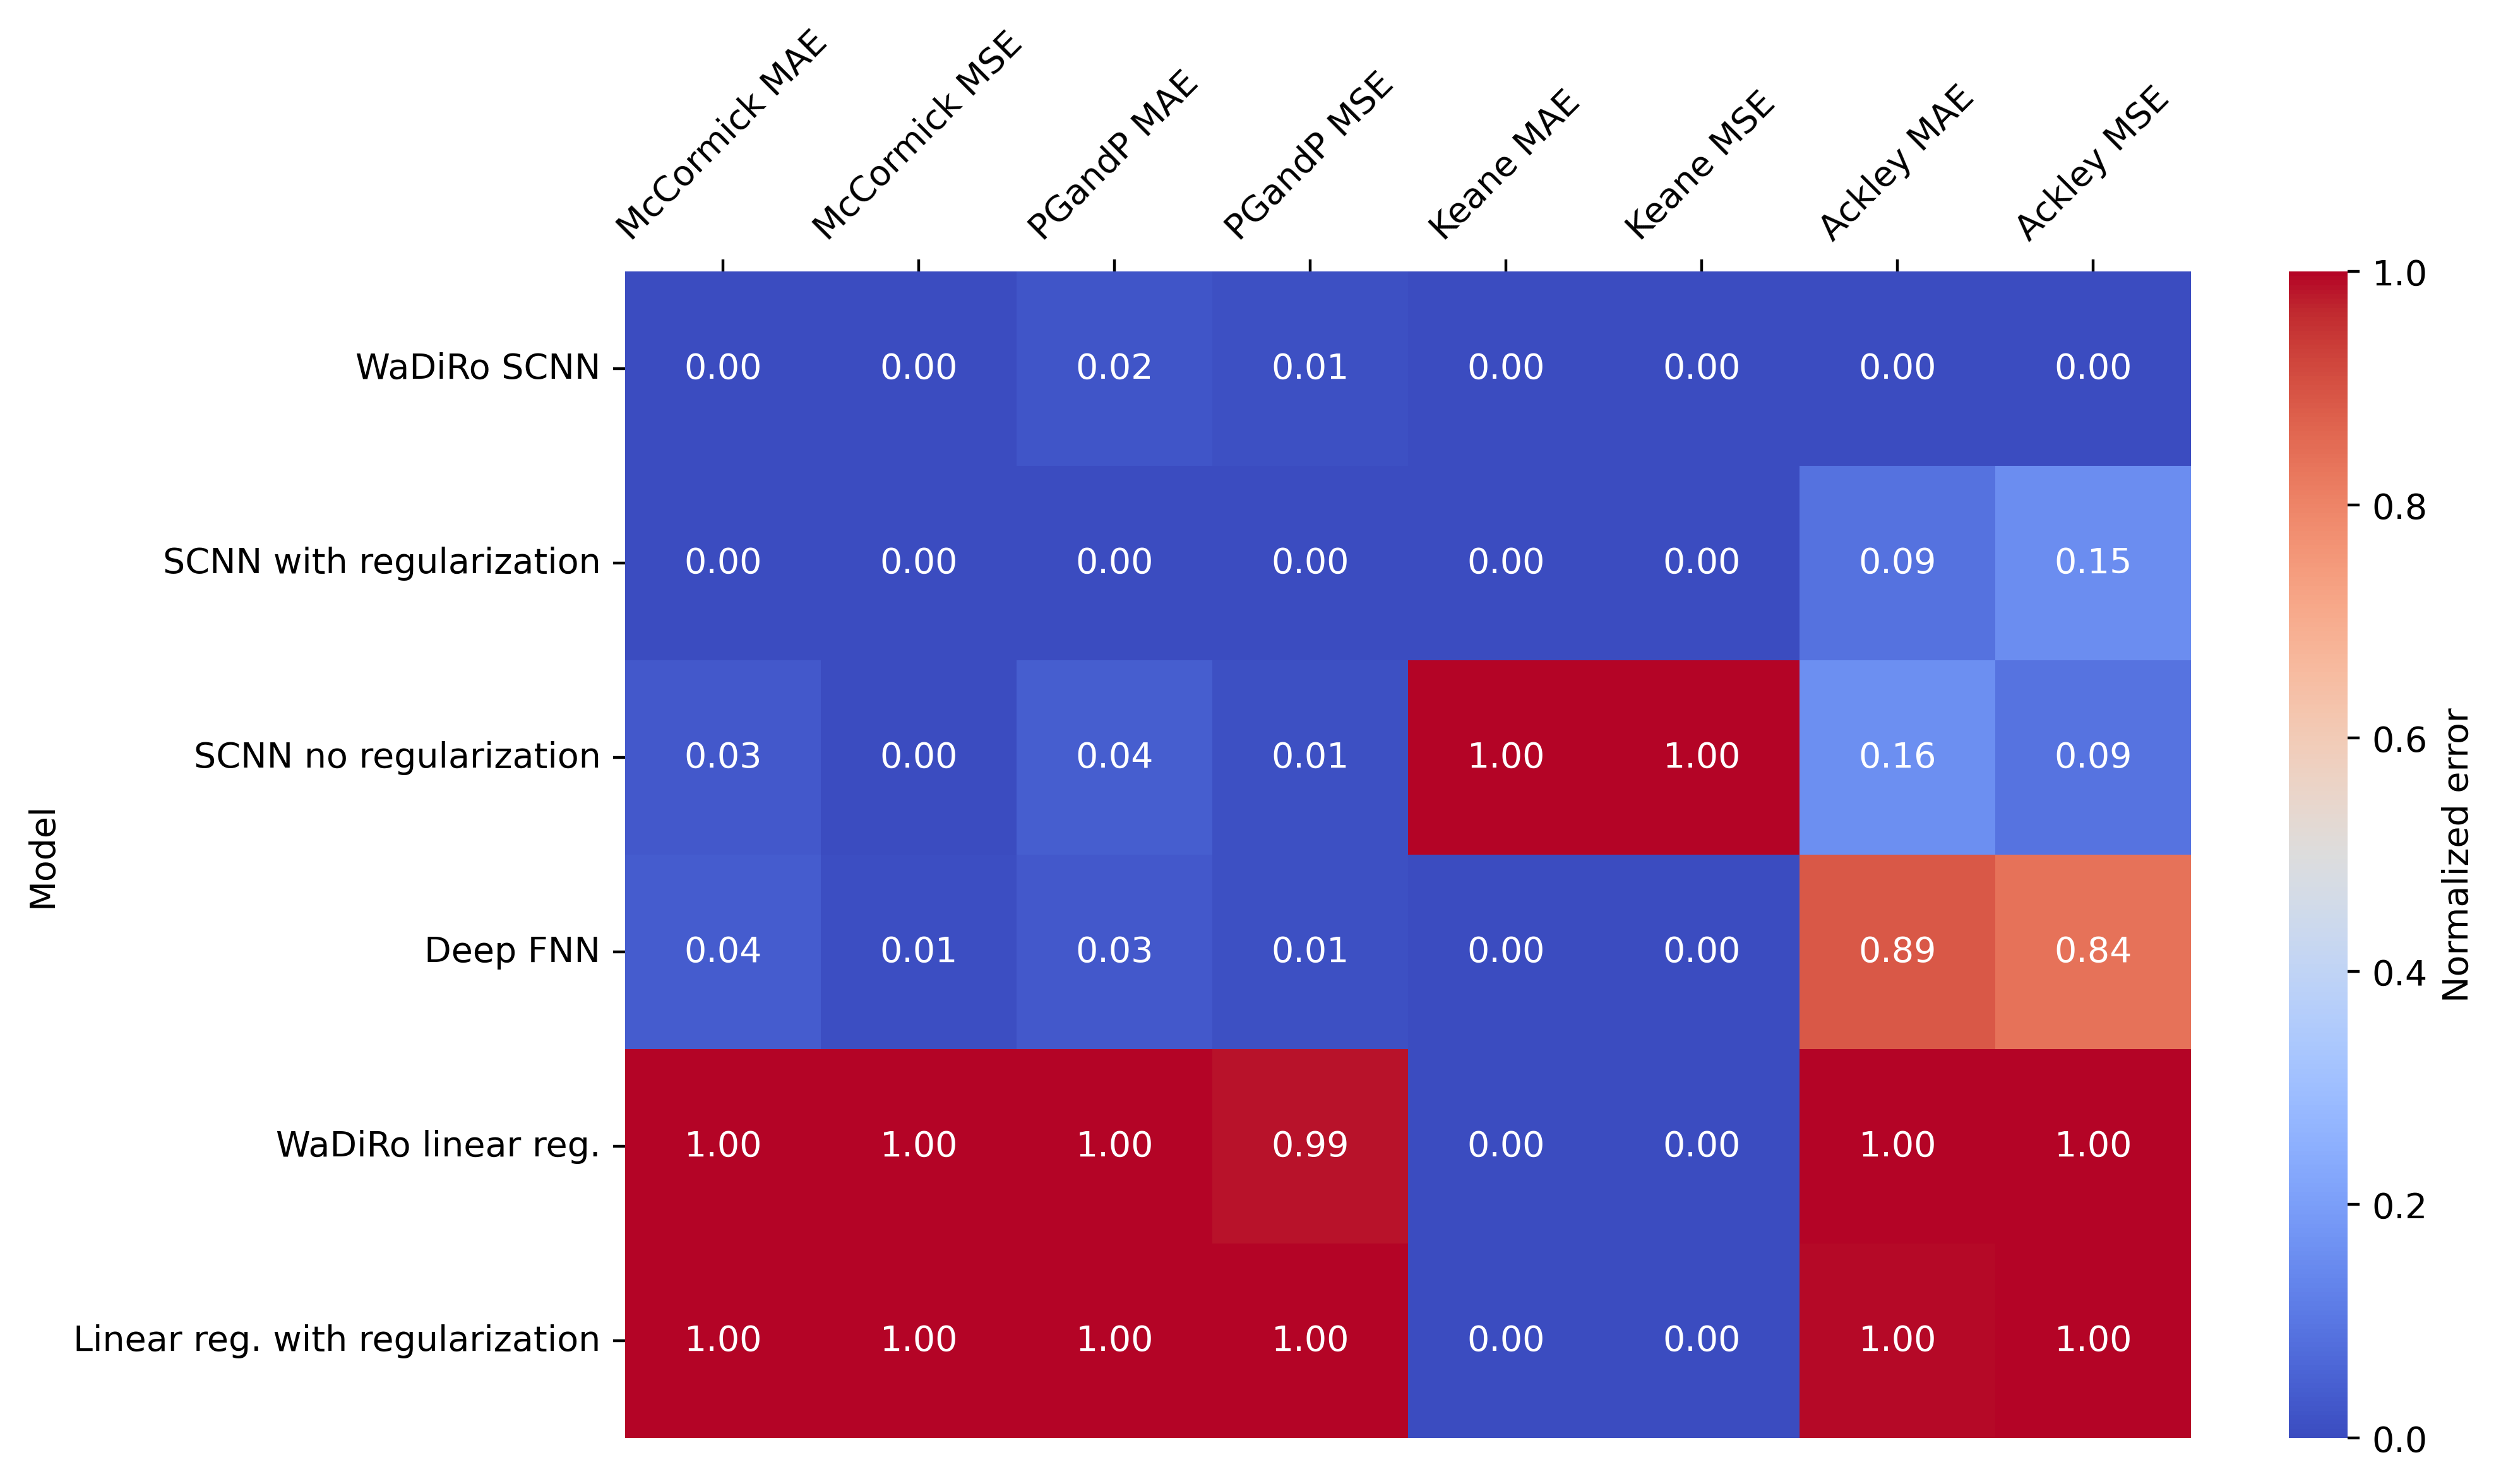

In [42]:
data = pd.DataFrame({
    'Model': ['WaDiRo SCNN', 'SCNN with regularization',  'SCNN no regularization', 'Deep FNN', 'WaDiRo linear reg.', 'Linear reg. with regularization',  ],
    'McCormick MAE': df_2['best_mae']['McCormick'].values,
    'McCormick MSE': df_2['best_mse']['McCormick'].values,
    'PGandP MAE': df_2['best_mae']['PichenyGoldsteinAndPrice'].values,
    'PGandP MSE': df_2['best_mse']['PichenyGoldsteinAndPrice'].values,
    'Keane MAE': df_2['best_mae']['Keane'].values,
    'Keane MSE': df_2['best_mse']['Keane'].values,
    'Ackley MAE': df_2['best_mae']['Ackley'].values,
    'Ackley MSE':  df_2['best_mse']['Ackley'].values
}).set_index('Model')

# Normalize each column by its range
data_norm = (data - data.min()) / (data.max() - data.min())

plt.figure(figsize=(10, 6), dpi = 400)
#plt.tight_layout()
cmap = sns.color_palette("coolwarm", as_cmap=True)
heatmap = sns.heatmap(data_norm, cmap=cmap, annot=True, fmt=".2f",cbar_kws={'label': 'Normalized error'})

# Set the function names as the y-axis labels
heatmap.set_yticklabels(heatmap.get_yticklabels(), rotation=0)

# Set the function names as the x-axis labels and place them on top
heatmap.set_xticklabels(data.columns, rotation=45)
heatmap.xaxis.tick_top()

#plt.title('Your caption here', y=-0.1)
#plt.title('Normalized error metrics for different models and benchmark functions')
plt.savefig('heatmap_JOPT.pdf', bbox_inches='tight')
plt.show()

In [ ]:


plt.figure(figsize=(10, 6), dpi = 400)
#plt.tight_layout()
cmap = sns.color_palette("coolwarm", as_cmap=True)
heatmap = sns.heatmap(data, cmap=cmap, annot=True, fmt=".2f",cbar_kws={'label': 'Error'})

# Set the function names as the y-axis labels
heatmap.set_yticklabels(heatmap.get_yticklabels(), rotation=0)

# Set the function names as the x-axis labels and place them on top
heatmap.set_xticklabels(data.columns, rotation=45)
heatmap.xaxis.tick_top()

#plt.title('Your caption here', y=-0.1)
#plt.title('Normalized error metrics for different models and benchmark functions')
plt.savefig('heatmap_JOPT_corruptBoth_bit_less_MAE.pdf', bbox_inches='tight')
plt.show()